following a guided project by andrej karpathy of creating micrograd which is a python module for backpropagation

In [40]:
import math 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2-4*x+5

In [3]:
f(3.0)

20.0

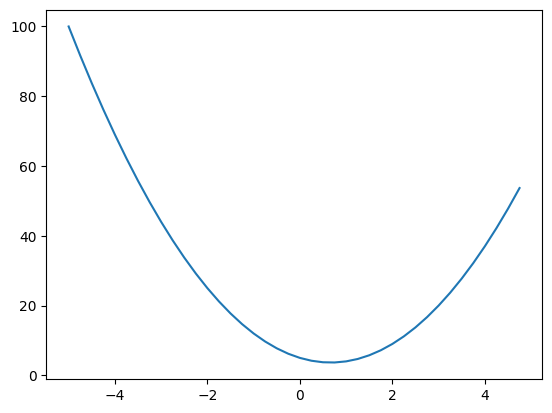

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [107]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        other =  other if isinstance(other, Value) else Value(other)#this allows us to add float or int to our value objects directly 
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad

        out._backward = _backward    
        return out
    
    def __radd__(self, other):
        return self+other
    
    def __mul__(self,other):
        other =  other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __truediv__(self,other):
        return self*other**-1
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self,other):
        return self+(-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other - 1))*out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2)*out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out 
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

L

Value(data = -8.0)

In [32]:
import sys
sys.path.append("/home/aayushjoshi/ML/MLenv/lib/python3.11/site-packages")

In [33]:
from graphviz import Digraph

this below is code directly copied from his github

In [38]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

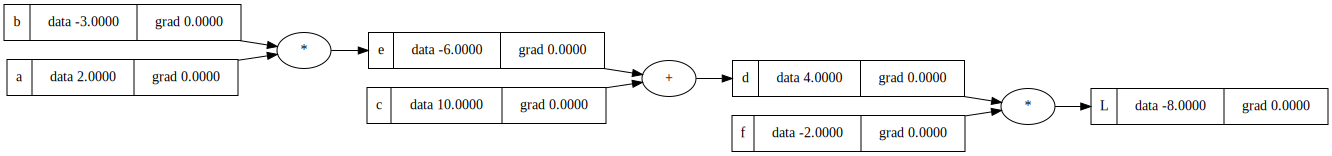

In [76]:
draw_dot(L)

here is an example of backpropagation using a vague neural network <br>
grad here refers to the derivative of loss function or the final output wrt the node that we are on

In [75]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.8813735870195432, label='b')#highly specific value that will give us good values that dont look hideous

x1w1 = x1*w1 ; x1w1.label='x1*w1'
x2w2 = x2*w2 ; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

for a neural network to work the best we need to fit the bias and weights really well to predict accurately that will happen if we are somehow able to make the loss function's gradient almost near zero 

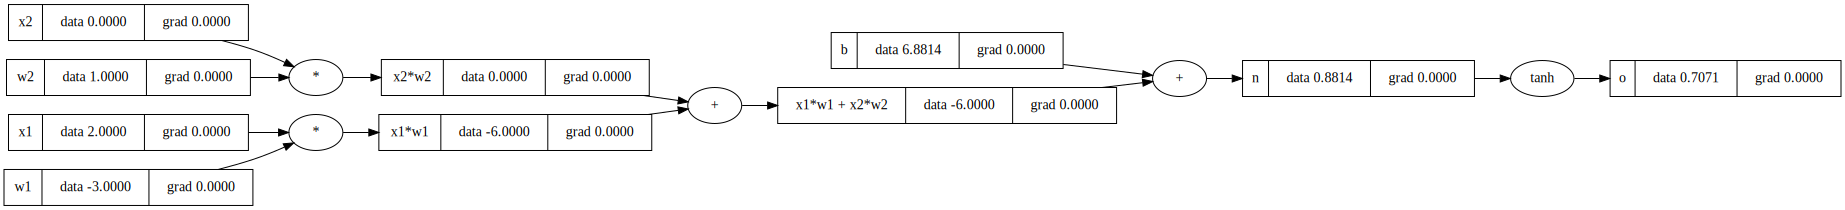

In [77]:
draw_dot(o)

you can see how we are moving back in the nodes finding the gradient and since we are moving abckwards this here is called backpropagation<br>though this is just manually back passing but we dont have to because now we have our function now that does that for us

In [56]:
#do/dn = 1 - tanh(n)**2
n.grad = 1 - o.data**2

x1w1.grad = 0.5
x2w2.grad = 0.5 

x2.grad = w2.data*x2w2.grad #this here comes by our beloved chain rule
w2.grad = x2.data*x2w2.grad

x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

even though we already have created the function to do that automatically for us we now need to that it in the order to keep it as "back"propagation

In [64]:
o.grad = 1.0
o._backward()

In [66]:
n._backward()

In [68]:
b._backward()

In [69]:
x1w1x2w2._backward()

In [70]:
x2w2._backward()

In [71]:
x1w1._backward()

now we want to create a function to call these backwards automatically<br>we are gonna use topological sort for that which is an algo used in graphs and the code for it is written above in our value implementation

In [73]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

topo


[Value(data = 6.881373587019543),
 Value(data = 0.0),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

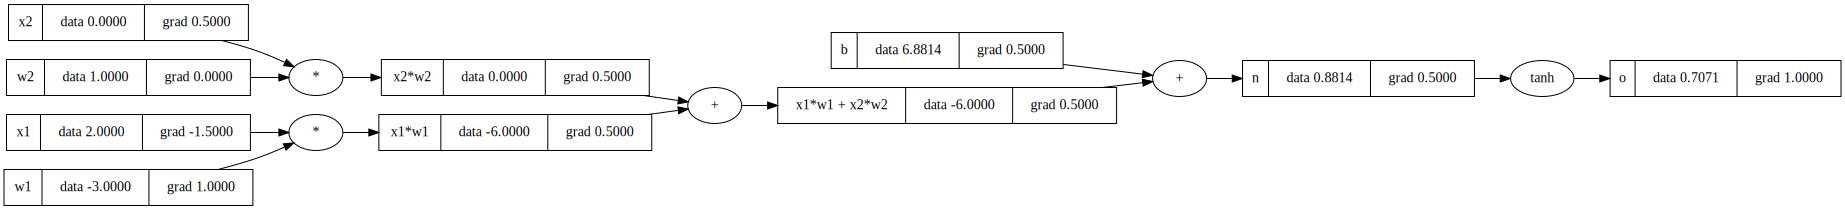

In [79]:
o.backward()#calling ourbackward function directly and now it does the task for us automatically
draw_dot(o)

now we have acheived something but there is a bug that when we use same value twice it is gonna fuck up the gradient for example

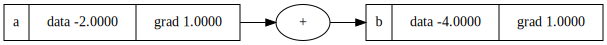

In [81]:
a = Value(-2.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)


issue can be solved just by replacing the = in backward function with += so that it doesnt uodates the values of the grad rather it increments it so it can be added<br>and just by that now we can see the correct answer there 

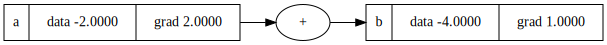

In [83]:
a = Value(-2.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)


In [96]:
a = Value(-2.0)
1 + a


Value(data = -1.0)

but something like 1+a wont work so we use rmul and radd

In [97]:
a.exp()

Value(data = 0.1353352832366127)

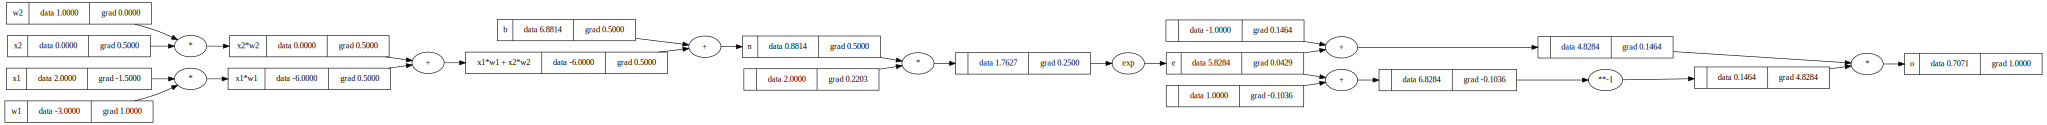

In [109]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.8813735870195432, label='b')#highly specific value that will give us good values that dont look hideous

x1w1 = x1*w1 ; x1w1.label='x1*w1'
x2w2 = x2*w2 ; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp(); e.label='e'
o = (e-1)/(e+1); o.label='o'#tanh gets broken into pieces 
o.backward()
draw_dot(o)

there is an issue with exp backward pass code <br>the increment doesnt works there and it messes up the whole thing so instead of that i had to use = (rather than +=)

now trying to implement the above written stuff using pytorch

In [110]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [114]:
import random

In [177]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]    
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip((self.w), x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]    
n = MLP(2, [4, 4, 1])
n(x)

Value(data = -0.8303880411366854)

now this image makes more reason to exit and it kinda looks lika a neural networ which is tbh not really that big<br><br>now comes the part where we are gonna apply what we created (ie micrograd) to backpropagate

In [178]:
xs = [
    [2.0, -3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0,5, 1.0, -1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]#desired targets

we want our neural net to give us hte following outputs when we put the examples list so we have created a binary classifier in simple terms

In [154]:
ypred = [n(x) for x in xs]
ypred#we want to change these results to our desired terms

[Value(data = 0.8764875109081658),
 Value(data = 0.2255945074380321),
 Value(data = 0.6886877511860727),
 Value(data = 0.564038161944008)]

the desired results are acheived by fine tuning the weights and biases of our neural net and to fine tune those we use loss function<br>what we wan to do mathematically is minimize the loss <br>what we mean by loss here is the difference between our predictions and the actual desired terms

In [155]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))#squared loss
loss

Value(data = 4.5590662768709675)

In [156]:
loss.backward()

In [157]:
n.layers[0].neurons[0].w[0].grad

-0.03890148239992641

each unit has a grad now which tells us how that particular unit affects the final result<br>higher pos grad means slighlty increase that term will increase our output by a really big number and vice versa

In [159]:
len(n.parameters())

37

In [160]:
for p in n.parameters():
    p.data += -0.05 * p.grad

we updated our values slightly and now our loss function should have decreased a bit so we will have to rerun those calcualtions <br>btw yk the learning rate and how to choose it and not funck up

In [162]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data = 4.469746129500648)

see slightly less than our previous loss<br> see now this has to be kept repeating <br>forward pass --> backward pass --> value upadte --> forward pass --> ....repeat

this is nothing but gradient descent applied for our neural network like we used to for our linear regression our logistic regression

In [174]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(f"iteration : {k+1}, loss : {loss.data}")

iteration : 1, loss : 6.421018876387199
iteration : 2, loss : 4.39862523038454
iteration : 3, loss : 3.426991351035051
iteration : 4, loss : 4.520449001334427
iteration : 5, loss : 4.5142450432246175
iteration : 6, loss : 0.22627223732543755
iteration : 7, loss : 0.20639371843062002
iteration : 8, loss : 0.5721222116820874
iteration : 9, loss : 0.07000917905669025
iteration : 10, loss : 0.19407553028061303
iteration : 11, loss : 0.21915722181221226
iteration : 12, loss : 0.0815402030800811
iteration : 13, loss : 0.01823296657302625
iteration : 14, loss : 0.014580687557527462
iteration : 15, loss : 0.02970107672153786
iteration : 16, loss : 0.0012939933175510443
iteration : 17, loss : 0.00040195591781029604
iteration : 18, loss : 0.0009644377226465693
iteration : 19, loss : 0.00293100353324327
iteration : 20, loss : 0.008371767893116128


In [175]:
ypred

[Value(data = 0.9999999273476348),
 Value(data = -0.9998886019923987),
 Value(data = -0.999999603302151),
 Value(data = 0.9085027023162029)]

idk why my ypred not that precise as andrejs went and why it went so slowly near to the value

okay so we fucked up a bit just like andrej did what we did is that we always incremented over the grad and didnt made it zero so we need to update our code there

In [179]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(f"iteration : {k+1}, loss : {loss.data}")

iteration : 1, loss : 6.33900185768635
iteration : 2, loss : 5.329865974994459
iteration : 3, loss : 4.186201705133428
iteration : 4, loss : 3.351775319389312
iteration : 5, loss : 2.935663091424794
iteration : 6, loss : 2.708039042863955
iteration : 7, loss : 2.5305350150283497
iteration : 8, loss : 2.2465956096968998
iteration : 9, loss : 1.892059310776561
iteration : 10, loss : 1.5742700629947837
iteration : 11, loss : 1.4441965291534888
iteration : 12, loss : 1.0408988869217817
iteration : 13, loss : 0.9260834732826557
iteration : 14, loss : 0.6646300322186462
iteration : 15, loss : 0.5466431823461698
iteration : 16, loss : 0.4472019959781311
iteration : 17, loss : 0.3850290328704279
iteration : 18, loss : 0.3266879890783395
iteration : 19, loss : 0.2765993760894945
iteration : 20, loss : 0.23841930719975457


now we get a pretty slow decent but it will still be kinda precise<br>you can always do more iterations to get closer

In [180]:
ypred

[Value(data = 0.8269030494562353),
 Value(data = -0.6757261747254562),
 Value(data = -0.8430107523425453),
 Value(data = 0.7195403500074119)]